### 1/ Importing the necessary packages

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import torch

from model import QNetwork
from dqn_agent import Agent

import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2/ Get The brain

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### Watch an untrained agent

In [4]:
# watch an untrained agent
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### Let's implement a DQN

In [5]:
def dqn(agent, scoreSolved = 20,n_episodes=3, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        while True:
            action = agent.act(state, eps)                 # select an action
            env_info = env.step(np.int32(action))[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0] 
            agent.step(state, action, reward, next_state, done)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=scoreSolved:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    #torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')#toRemoveafter2000episodetest
    return agent, scores


### Train the agent
In this part, we'll train 10 agent for 650 episodes in order to have a good average of the scores.

In [6]:

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

numAgent = 12
numEpisodes = 650
avgDQNscores = [0]*numEpisodes


for i in range (numAgent):
    print("\nAgent number ",i+1)
    DQNagent = Agent(QNetwork, state_size, action_size, seed=0)
    DQNagent, DQNscores = dqn(DQNagent,n_episodes = numEpisodes)
    avgDQNscores = np.array(avgDQNscores) + DQNscores

    
avgDQNscores = np.array(avgDQNscores)/numAgent



Agent number  1
Episode 100	Average Score: 1.10
Episode 200	Average Score: 3.34
Episode 300	Average Score: 7.24
Episode 400	Average Score: 7.56
Episode 500	Average Score: 10.85
Episode 600	Average Score: 13.24
Episode 650	Average Score: 13.95
Agent number  2
Episode 100	Average Score: 0.96
Episode 200	Average Score: 5.07
Episode 300	Average Score: 7.64
Episode 400	Average Score: 8.51
Episode 500	Average Score: 12.13
Episode 600	Average Score: 14.35
Episode 650	Average Score: 15.07
Agent number  3
Episode 100	Average Score: 0.66
Episode 200	Average Score: 3.77
Episode 300	Average Score: 7.12
Episode 400	Average Score: 9.49
Episode 500	Average Score: 12.41
Episode 600	Average Score: 12.89
Episode 650	Average Score: 13.91
Agent number  4
Episode 100	Average Score: 0.45
Episode 200	Average Score: 4.56
Episode 300	Average Score: 7.45
Episode 400	Average Score: 8.76
Episode 500	Average Score: 12.06
Episode 600	Average Score: 13.25
Episode 650	Average Score: 13.84
Agent number  5
Episode 100

### rough learning curve
Plot the average of the score  episode by episode.

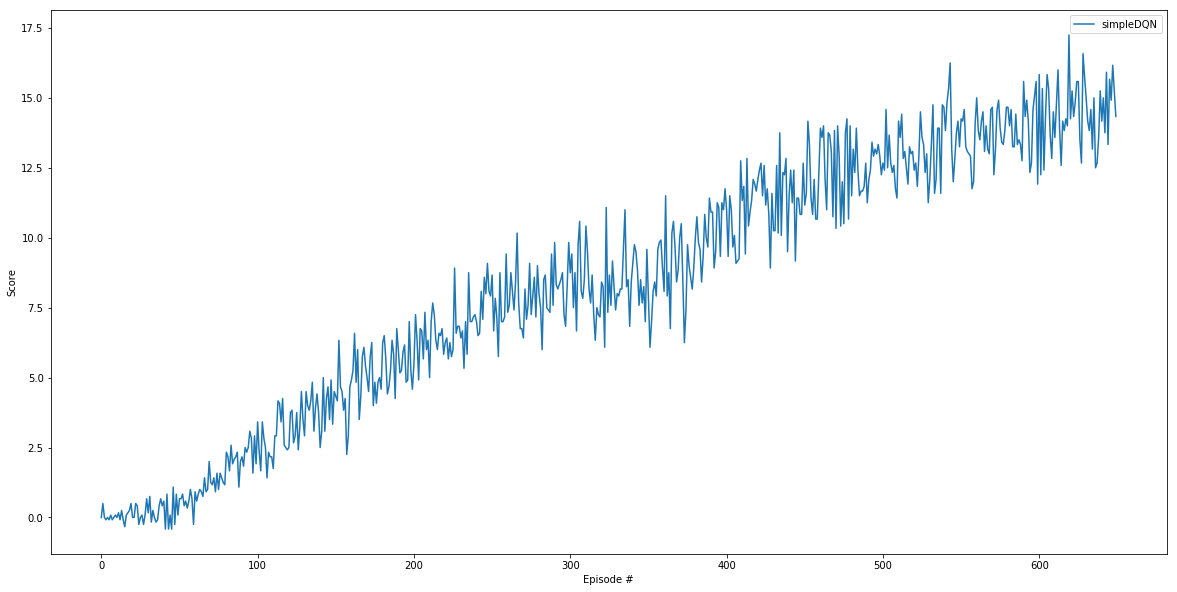

In [7]:


# plot the scores
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(avgDQNscores)), avgDQNscores, label='simpleDQN')
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


### Smoothed learning curve
plot the average of the score.
window gives us the ability to smooth the curve. For exemple, for the 120th episode, we will average episode 20 to 120 if window = 100.

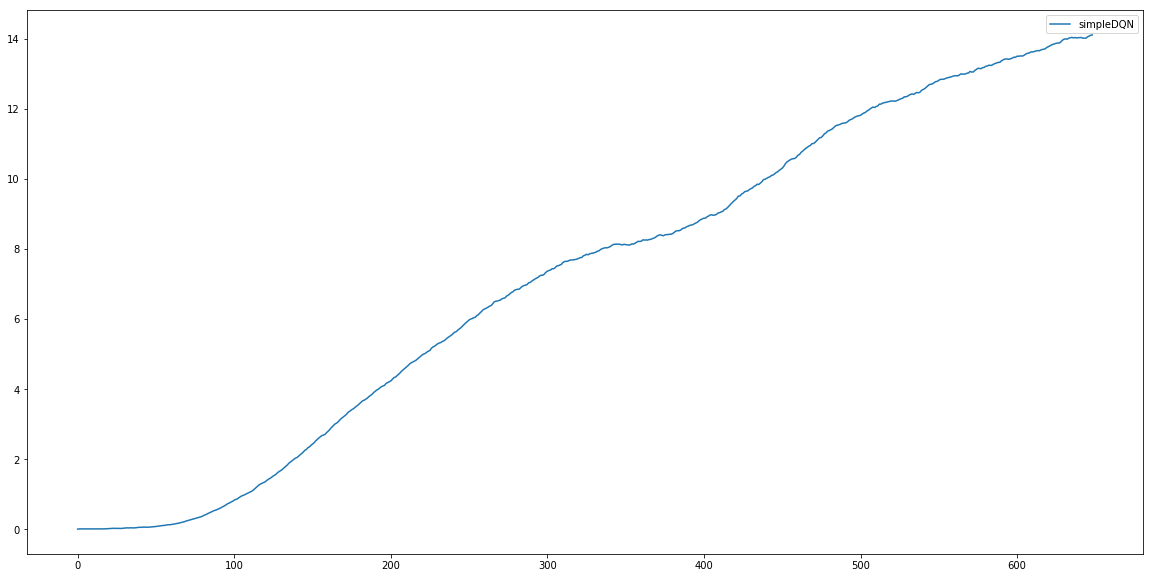

In [16]:

window = 100
filter = np.ones(window)/window
plt.figure(figsize=(20,10))
plt.plot(np.convolve(avgDQNscores, filter)[:-window], label='simpleDQN')
plt.legend()
plt.show()

### Load and watch a trained agent
Here the agent tested has been trained for 2000 episodes with  DQN.

Score is 19.0


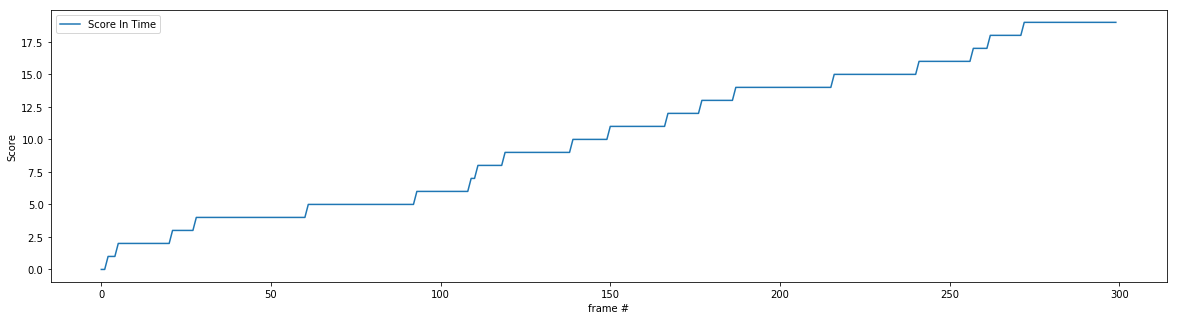

In [9]:
agent = Agent(QNetwork, state_size, action_size, seed=0)


agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0
scoreInTime = []
while True:
    action = agent.act(state, 0)
    env_info = env.step(np.int32(action))[brain_name]        # send the action to the environment

    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    
    score += reward# update the score
    scoreInTime.append(score)
    state = next_state                             # roll over the state to next time s

    if done:
        break 
        
print('Score is', score)


# plot the score in time
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scoreInTime)), scoreInTime, label='Score In Time')
#window = 50
#filter = np.ones(window)/window
#plt.plot(np.convolve(scoreInTime, filter)[:-window], label='Smoothed Score')
plt.legend()
plt.ylabel('Score')
plt.xlabel('frame #')
plt.show()